In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import ipywidgets as widgets
import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import matplotlib.pyplot as plt
from utils import sampling
from scipy.stats import theilslopes
from ismn.interface import ISMN_Interface
from pytesmo.df_metrics import ubrmsd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

# Data sets for this lecture

## Summary

In this lecture we will compute the following soil moisture anomaly based drought indices using monthly soil moisture data from C3S.

* Soil Moisture anomalies
* Anomaly Quantiles
* Z-Scores
* Soil Moisture Anomaly Percentage Index (SMAPI)

In addition we will use ECMWF ERA-5 monthly precipitation data to compute
* Standardised Precipitation Index (SPI)

First we load our soil moisture stack. In this case use the same stack as the one from the previous lecture on satellite soil moisture retrieval. The data is produced as part of the Copernicus Climate Change Service (C3S), which combines retrievals from multiple passive sensors. The used subset contains monthly mean values for Europe from 1978 to September 2022.
More information on this data can be found in the [C3S Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-soil-moisture?tab=overview).

In [2]:
c3s_europe = xr.open_dataset('./LTC_DATA/STACK_C3S-SOILMOISTURE_EUROPE_v202012_PASSIVE_MONTHLY.nc')
display(c3s_europe)

<xarray.Dataset>
Dimensions:  (lat: 160, lon: 240, time: 527)
Coordinates:
  * lat      (lat) float32 69.88 69.62 69.38 69.12 ... 30.88 30.62 30.38 30.12
  * lon      (lon) float32 -14.88 -14.62 -14.38 -14.12 ... 44.38 44.62 44.88
  * time     (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2022-09-01
Data variables:
    nobs     (time, lat, lon) float32 ...
    sm       (time, lat, lon) float32 ...
    sm_anom  (time, lat, lon) float32 ...
Attributes: (12/43)
    title:                      C3S Surface Soil Moisture merged PASSIVE Product
    institution:                EODC (AUT); TU Wien (AUT); VanderSat B.V. (NL)
    contact:                    C3S_SM_Science@eodc.eu
    source:                     LPRMv6/SMMR/Nimbus 7 L3 Surface Soil Moisture...
    platform:                   Nimbus 7, DMSP, TRMM, AQUA, Coriolis, GCOM-W1...
    sensor:                     SMMR, SSM/I, TMI, AMSR-E, WindSat, AMSR2, SMO...
    ...                         ...
    time_coverage_start:        1978-10-31T12:00:00Z
    time_coverage_end:          1978-11-30T12:00:00Z
    time_coverage_duration:     P1M
    NCO:                        netCDF Operators version 4.7.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    history_of_appended_files:  Mon May  3 22:50:40 2021: Appended file /home...

In addition we load precipitation data from ECMWF's ERA5 reanalysis (called `total precipitation` or `tp`). We have downloaded monthly averages for Europe in a similar time range as the soil moisture data. We sum up the (average) rainfall amount for each month. More background information on how to correctly sum-up precipitation data is available in the [support portal](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790). 
ERA5 monthly means are available through the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview).

In [3]:
era5_europe = xr.open_dataset('./LTC_DATA/era5_tp.nc').sel(time=slice('1978-01-01',None))

days_in_month = pd.DatetimeIndex(era5_europe.time).days_in_month.values
era5_europe['tp'].values = era5_europe['tp'].values * 1000 * days_in_month.reshape(len(days_in_month), 1, 1)
display(era5_europe)

<xarray.Dataset>
Dimensions:    (longitude: 241, latitude: 161, time: 528)
Coordinates:
  * longitude  (longitude) float32 -15.0 -14.75 -14.5 -14.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 1978-01-01 1978-02-01 ... 2021-12-01
Data variables:
    tp         (time, latitude, longitude) float64 57.02 57.56 ... 5.79 5.437
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-20 15:35:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# Loading data for the following examples
Droughts are extreme events in time. We therefore use time series as inputs to compute the indices. The following example allows you to extract the soil moisture and precipitation data for a chosen point in Europe. The left plot shows the location of the extracted time series.
We extract a time series for both data sets from our stacks and combine them in a pandas DataFrame for further processing. The figure on the right shows the extracted values for the chosen location and time period.

**Try:**

* **Changing the coordinates and see what a time series for a different location than the default one looks like. Find a suitable time series for the rest of the lecture or keep the default one in N-W Italy.**

You can always reset the interactive controls by re-running the cell.

<font color='red'>**Note: The data you finally choose here will be used in the rest of the notebook**</font>

In [4]:

extracted_ts = dict()

slider=widgets.IntRangeSlider(min=1979, max=2021, value=[1991, 2021], step=1, description='Time series range (year from, year to)', 
                              continuous_update=False, style={'description_width': 'initial'}, layout=widgets.Layout(width='30%'))
@widgets.interact(period=slider, Longitude="8.625", Latitude="44.625")
def extract_ts(period, Longitude, Latitude):
    lon, lat = float(Longitude), float(Latitude)
    
    # Extract a pandas time series at location
    ts_sm = c3s_europe.sel(lon=lon, lat=lat, method='nearest') \
                   .to_pandas().rename(columns={'sm': 'soil_moisture'}) \
                   .loc[f"{period[0]}-01-01":f"{period[1]}-12-31", ['soil_moisture']]
    
    ts_tp = era5_europe.sel(longitude=lon, latitude=lat, method='nearest') \
               .to_pandas().rename(columns={'tp': 'precipitation'}) \
               .loc[f"{period[0]}-01-01":f"{period[1]}-12-31", ['precipitation']]
    
    ts = pd.concat([ts_sm, ts_tp], axis=1).resample('MS').mean()

    # Set up figures
    fig = plt.figure(figsize=(15,4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    map_ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ts_ax = fig.add_subplot(gs[0, 1:])
    bar_ax = ts_ax.twinx()

    # Plot overview map
    map_ax.set_extent([-14, 46, 29, 71])
    map_ax.add_feature(cartopy.feature.LAND, zorder=0)
    map_ax.add_feature(cartopy.feature.BORDERS)
    map_ax.coastlines()
    map_ax.plot([lon], [lat], 'ro', transform=ccrs.PlateCarree())
    map_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    
    # Plot time series
    
    ts['soil_moisture'].plot(style='-o', ax=ts_ax, label='soil moisture')
    ts['precipitation'].plot.area(ax=bar_ax, alpha=0.25, label='precipitation', linewidth=0)
    
    ts_ax.set_xlabel('Time [Year]')
    ts_ax.set_ylabel(f'Soil moisture $[m³/m³]$')
    bar_ax.set_ylabel(f'Precipitation $[mm]$')
    ts_ax.set_title('Satellite Soil Moisture and ERA5 Precipitation')
    
    ts_ax.legend(loc='upper left')
    bar_ax.legend(loc='upper right')
    
    # Make data available for the next example
    global extracted_ts
    extracted_ts = dict(data=ts.copy(), lon=lon, lat=lat)

interactive(children=(IntRangeSlider(value=(1991, 2021), continuous_update=False, description='Time series ran…

# Compute anomalies for the chosen location
Here we use the time series that was extracted in the previous example.

We now compute the average soil moisture conditions for each month using data from all years within the selected reference period (called **Climatology**, resp. $\overline{SM}$). 
The deviation of the absolute values ($SM$) from this climatological reference are the soil moisture **Anomalies**. Values close to 0 therefore indicate normal conditions, while negative anomalies indicate drier than usual conditions (droughts). In case of strong precipitation events, positive anomalies are found.

$\Large SMA = SM_{k,i} - \overline{SM_i}$

**Try:**
    
* **Changing the baseline / reference period to see if / how it affects the climatology computation.**
* **Changing the amount of smoothing applied to the climatology.**

*Note: You can always reset the interactive controls by re-running the cell.*

In [5]:
anomaly_ts = None

@widgets.interact(baseline=widgets.IntRangeSlider(min=1991, max=2021, value=[1991, 2020], step=1, style={'description_width': 'initial'}, 
                                                  description='Reference period (year from, year to):', layout=widgets.Layout(width='30%')), 
                  smoothing=widgets.Dropdown(options=['strong', 'medium', 'none'], value='medium', style={'description_width': 'initial'}, description='Smoothing of climatology'))
def plot_components(baseline, smoothing):
    """
    Compute climatology and anomalies for the loaded soil moisture time series
    """
    loc = f"Lon: {extracted_ts['lon']}°, Lat: {extracted_ts['lat']}°" 
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 7))
    ts = extracted_ts['data'].copy().loc['1991-01-01':,:]
    
    clim_data = ts['soil_moisture'].loc[f'{baseline[0]}-01-01':f'{baseline[1]}-12-31']
    clim_std = pd.Series(clim_data.groupby(clim_data.index.month).std(), name='climatology_std')      
    clim_mean = pd.Series(clim_data.groupby(clim_data.index.month).mean(), name='climatology')
    
    if smoothing.lower() == 'medium':
        window = 3
    elif smoothing.lower() == 'strong':
        window = 5
    else:
        window = 0
    
    if window != 0:
        clim_mean = clim_mean.rolling(window, min_periods=1).mean()              
    
    ts = ts.join(on=ts.index.month, other=clim_mean)
    ts['climatology_std'] = ts.join(on=ts.index.month, other=clim_std)['climatology_std']
    ts['anomaly'] = ts['soil_moisture'] - ts['climatology']
    
    ts['soil_moisture'].plot(ax=axs[0], title=f'Soil Moisture (absolute) at {loc}', ylabel=f'SM $[m³/m³]$', xlabel='Time [Year]')
    for i, g in clim_data.groupby(clim_data.index.year):
        axs[1].plot(range(1,13), g.values, alpha=0.2)
        
    clim_mean.plot(ax=axs[1], color='blue', title=f'Climatology at {loc}', ylabel='SM $[m³/m³]$', xlabel='Time [Month]', label='mean')
    clim_std.plot(ax=axs[1], label='$\sigma$')
    axs[1].legend()
    
    global anomaly_ts
    anomaly_ts = ts.copy()
    
    axs[2].axhline(0, color='k')
    axs[2].fill_between(ts['anomaly'].index,ts['anomaly'].values,where=ts['anomaly'].values>=0, color='blue')
    axs[2].fill_between(ts['anomaly'].index,ts['anomaly'].values,where=ts['anomaly'].values<0, color='red')
    axs[2].set_ylabel('SM $[m³/m³]$')
    axs[2].set_xlabel('Time [Year]')
    axs[2].set_title(f"SM Anomalies at {loc}")
    plt.tight_layout()



interactive(children=(IntRangeSlider(value=(1991, 2020), description='Reference period (year from, year to):',…

## Mapped Quantiles

A simple way to classify potential droughts is by applying thresholds based on quantiles of anomalies in a given time series. Extremely low anomaly values therefore correspond to droughts, while anomalies around and above zero do not. Finding meaningful thresholds is difficult only meaningful when long enough time series are available.

**Try:**

* **Changing the theshold values for the quantile-based discretization function find a meaningful classification for the time series you have chosen above.**

*Note: You can always reset the interactive controls by re-running the cell.*

In [13]:
df = anomaly_ts.copy()

@widgets.interact(
mild=widgets.FloatSlider(value=0.2, min=0, max=0.5, step=0.01),
moderate=widgets.FloatSlider(value=0.1, min=0, max=0.5, step=0.01),
significant=widgets.FloatSlider(value=0.05, min=0, max=0.5, step=0.01),
severe=widgets.FloatSlider(value=0.02, min=0, max=0.5, step=0.01),
extreme=widgets.FloatSlider(value=0.01, min=0, max=0.5, step=0.01),
continuous_update=False)
def plot(mild=0.2, moderate=0.1, significant=0.05, severe=0.02, extreme=0.01):
    bins = df['anomaly'].quantile([0, extreme, severe, significant, moderate, mild, 1.]).values

    fig, ax = plt.subplots(1,1, figsize=(15, 3))
    ax.axhline(0, color='k', linestyle='--')
    ax.axhspan(bins[4], bins[5], color='#fee5d9', alpha=0.5, label='mild')
    ax.axhspan(bins[3], bins[4], color='#fcbba1', alpha=0.5, label='moderate')
    ax.axhspan(bins[2], bins[3], color='#fc9272', alpha=0.5, label='significant')
    ax.axhspan(bins[1], bins[2], color='#fb6a4a', alpha=0.5, label='severe')
    ax.axhspan(bins[0], bins[1], color='#de2d26', alpha=0.5, label='extreme')
    
    p = df['anomaly'].plot(marker='o', color='black', ax=ax, ylabel='SM Anomaly $[m³/m³]$', 
                           title=f"Soil Moisture Anomaly drought classification at Lon: {extracted_ts['lon']}°, Lat: {extracted_ts['lat']}°")
    plt.legend()

interactive(children=(FloatSlider(value=0.2, description='mild', max=0.5, step=0.01), FloatSlider(value=0.1, d…

## Z-Scores
Z-scores are a way of standardising values from different normal distributions. Z-scores show the number of standard deviations from the mean of the sample.

$\Large Z = \frac{x - \mu}{\sigma}$

In the case of soil moisture anomalies, the distributions of values within a year can vary, e.g. due to differences in data coverage (i.e. a different distribution for values in summer than for those in winter). This can affect the computed climatology and therefore the derived anomalies. By taking into account the standard deviation of samples used to compute the climatologies, we can normalize the anomalies and reduce intra-annual biases.

$\Large Z_{k,i} = \frac{SM_{k,i} - \overline{SM_i}}{\sigma_{i}}$

**Try:**

* **Compare the Z-score time series to the anomaly time series above.**
* **Change the threshold values for the quantile-based discretization function find a meaningful classification for the time series you have chosen above.**
* **Extract a time series in areas where data coverage varies strongly within a year and compare the output.**


In [7]:
df = anomaly_ts.copy()

@widgets.interact(
moderate=widgets.FloatSlider(value=1, min=0, max=10, step=0.25),
extreme=widgets.FloatSlider(value=3, min=0, max=10, step=0.25),
continuous_update=False)
def plot(moderate, extreme):
    df.loc[:, 'zscore'] = (df['soil_moisture'] - df['climatology']) / df['climatology_std']
    bins = [df['zscore'].min(), -extreme, -moderate, 0]

    fig, ax = plt.subplots(1,1, figsize=(15, 3))
    ax.axhline(0, color='k', linestyle='--')
    ax.axhspan(bins[1], bins[2], color='#fc9272', alpha=0.5, label='moderate')
    ax.axhspan(bins[0], bins[1], color='#de2d26', alpha=0.5, label='extreme')
    df['zscore'].plot(marker='o', color='black', ax=ax, ylabel='z score [-]', 
                      title=f"Soil Moisture Z-Score drought classification (Lon: {extracted_ts['lon']}°, Lat: {extracted_ts['lat']}°)")
    plt.legend()


interactive(children=(FloatSlider(value=1.0, description='moderate', max=10.0, step=0.25), FloatSlider(value=3…

## SMAPI & relative anomalies
The **Soil Moisture Percetage Index (SMAPI)** ([Liu et al., 2019](https://doi.org/10.1016/j.rse.2018.10.026)) uses the difference between the observation and the (moving) average of the time series to express the anomaly relative to these average conditions.

$\Large SMAPI_{k,i}=\frac{SM_{k,i} - \overline{SM_i}}{\overline{SM_i}} \cdot 100\% $

In a similar way, **Relative Anomalies** express the deviation from the climatological mean in percent. 

$\Large SMA_{k,i} = \frac{SM_{k,i} - \overline{SM_i}}{\overline{SM_i}} \cdot 100\% $

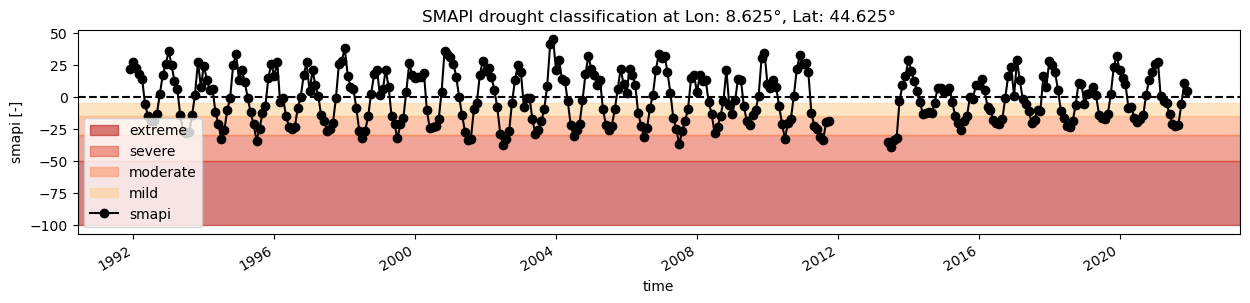

In [8]:
df = anomaly_ts.copy()
df['rolling'] = df['soil_moisture'].rolling(12).mean()
# df[['avg', 'soil_moisture']].plot()
df.loc[:, 'smapi'] = (df['soil_moisture'] - df['climatology']) / df['climatology'] * 100
bins = [-100, -50, -30, -15, -5, df.smapi.max()]
df.loc[:,'smapi_mapped'] = pd.cut(df.smapi, bins, labels=['extreme', 'severe', 'moderate', 'mild', 'no_drought'])

fig, ax = plt.subplots(1,1, figsize=(15, 3))
ax.axhline(0, color='k', linestyle='--')
ax.axhspan(bins[0], bins[1], color='#b30000', alpha=0.5, label='extreme')
ax.axhspan(bins[1], bins[2], color='#e34a33', alpha=0.5, label='severe')
ax.axhspan(bins[2], bins[3], color='#fc8d59', alpha=0.5, label='moderate')
ax.axhspan(bins[3], bins[4], color='#fdcc8a', alpha=0.5, label='mild')
p = df['smapi'].plot(marker='o', color='black', ax=ax, ylabel='smapi [-]', 
                     title=f"SMAPI drought classification at Lon: {extracted_ts['lon']}°, Lat: {extracted_ts['lat']}°")
plt.legend()



## Standardized Precipitation Index

Here we compute SPI values for the previously extracted precipitation time series (see first cell in this chapter).
SPI can be computed for different integration time lengths.

SPI values can be aggregated to get an estimate for the duration, severity and intensity of a drought.

1) **Duration**: Number of consecutive time stamps where SPI < 0
2) **Severity**: $\sum{SPI}$ over the duration of a drought
3) **Intensity**: $ \frac{Severity}{Duration}$

**Try:**
* **Changing the integration time length and see how it affects the SPI time series**
* **Choosing a different location in the data extraction cell above, re-run this cell and see how SPI changes**

In [9]:
from scipy.stats import gamma, norm

ts = extracted_ts['data'].copy().to_xarray()

def calc_zscore(ts):
    fit_alpha, fit_loc, fit_beta = gamma.fit(ts)
    pvals = gamma(fit_alpha, loc=fit_loc, scale=fit_beta).cdf(ts)
    zscore = norm.ppf(pvals)
    return zscore

def calc_spi_integrationtime(ts, integrationtime=None):
    if (integrationtime is not None) and (integrationtime!=0):
        ts = ts.rolling(time=integrationtime).mean().dropna("time")
    spi = ts.groupby('time.month').map(calc_zscore)
    return spi

def index_metrics(index):
    duration = [0]
    severity = [0]

    for i in index:
        if i < 0:
            duration.append(duration[-1] + 1)
            severity.append(severity[-1] + i)
        else:
            duration.append(0)
            severity.append(0)
    
    duration = np.array(duration[1:])
    severity = np.array(severity[1:])
    
    return duration, severity


@widgets.interact(integration_time=widgets.Dropdown(options=[0, 1, 2, 3, 12, 48], value=12, description='Integration Time [Months]:', style={'description_width': 'initial'}))
def plot_spi(integration_time):
    spi = pd.DataFrame(data={'index': calc_spi_integrationtime(ts['precipitation'], integration_time).to_pandas()})
    
    duration, severity = index_metrics(spi['index'])
    
    spi.loc[:, 'duration'] = duration
    spi.loc[:, 'severity'] = severity
    spi.loc[:, 'intensity'] = spi['severity'] / spi['duration']
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 5))
    
    axs[0, 0].fill_between(spi['index'].index, spi['index'].values, where=spi['index'].values>=0, color='blue')
    axs[0, 0].fill_between(spi['index'].index, spi['index'].values, where=spi['index'].values<0, color='red')
    axs[0, 0].set_ylabel('SPI[-]')
    axs[0, 0].set_title(f"SPI-{integration_time} at Lon: {extracted_ts['lon']}°, Lat: {extracted_ts['lat']}°")
    
    spi['intensity'].fillna(0).plot(title=f'Intensity', ax=axs[1, 0], ylabel='Severity / Duration')
    spi['duration'].plot(title=f'Duration', ax=axs[0, 1], ylabel='months')
    spi['severity'].plot(title=f'Severity', ax=axs[1, 1], ylabel="$\sum{SPI}$")
    plt.tight_layout()


interactive(children=(Dropdown(description='Integration Time [Months]:', index=4, options=(0, 1, 2, 3, 12, 48)…

# Other indices

## SMASI
Another index that was shown in the lecture is the Standardised Vegetation Optical Depth Index [(Moesinger et al., 2022)](https://doi.org/10.5194/bg-19-5107-2022).
A similar method was applied to different active and passive soil moisture products to make them comparable and create a long-term index. The following time series contains harmonised indices from 4 satellites.

The plot below shows the SMASI index for the point in NW-Italy (Lon: 8.625°, Lat: 44.625°).

**Try:**

* **Comparing this index to the other ones above**

In [14]:
smasi = pd.read_csv('./LTC_DATA/smasi_8.625_44.625.csv', index_col=0, parse_dates=True).loc['1991-01-01':,:].rename(columns={'sm_index_4x': 'index'})

@widgets.interact(resample=widgets.Dropdown(options=['daily', '10-daily', 'monthly', '3-monthly', 'yearly'], value='daily', description='Resampling:', 
                                            style={'description_width': 'initial'}))
def plot_smasi(resample=None):
    smasi_mean = smasi.copy()
    
    smasi_mean = smasi_mean[~smasi_mean.index.duplicated(keep='first')]
    smasi_mean = smasi_mean.resample(sampling[resample]).mean()
        
    fig, ax = plt.subplots(1,1, figsize=(15, 3))
    smasi_mean.plot(ax=ax, ylabel='SMASI[-]', title='SMASI at Lon: 8.625°, Lat: 44.635°')
    plt.axhline(0, color='k', linestyle='--')

interactive(children=(Dropdown(description='Resampling:', options=('daily', '10-daily', 'monthly', '3-monthly'…

# Soil Moisture / VOD Lag analysis

For this final example use pre-processed, daily, average VOD and soil moisture time series for larger study areas (bounding boxes around France, Italy, Spain and Europe). We then compute cross-correlation values between the soil moisture and VOD time series with a number of lags applied to the soil moisture data. 

<img src="img/study_areas.png" width="30%"/>


**Try:**
* **Changing the study area and see if you find differences in the computed cross correlations**.
* **Changing the range of lags that is applied to the soil moisture data (positive values refer to shifts forward in time)**
* **What causes these patterns and when do they repeat?**

In [55]:
def crosscorr(vod, sm, lag=0):
    return vod.corr(sm.shift(lag))

slider = widgets.IntRangeSlider(min=-366, max=366, value=[0, 200], step=1, style={'description_width': 'initial'}, description='Lags (days): (min, max):', continuous_update=False)
dropdown = widgets.Dropdown(options=['Europe', 'France', 'Spain', 'Italy'], value='Italy', description='Study area:', style={'description_width': 'initial'})
@widgets.interact(study_area=dropdown,lags=slider)
def plot(study_area, lags, Anomalies: bool = False):
    vod_var, sm_var = 'anomaly' if Anomalies else 'vod_K', 'sm_anomaly' if Anomalies else 'sm'
    df_vod = pd.read_csv(f'./LTC_DATA/mean_ts/vod_{study_area.lower()}.csv', index_col=0, parse_dates=True)[vod_var]
    df_sm = pd.read_csv(f'./LTC_DATA/mean_ts/c3s_{study_area.lower()}.csv', index_col=0, parse_dates=True)[sm_var]
    df = pd.concat([df_vod.loc['2000-01-01':'2020-12-31'], df_sm['1991-01-01':'2020-12-31']], axis=1)
    x = np.arange(lags[0], lags[1], 1)
    plt.plot(x, np.array([crosscorr(df[vod_var], df[sm_var], lag=lag) for lag in x]))
    plt.title(f"SM / VOD {'anomaly' if Anomalies else ''} cross-correlation ({study_area})")
    plt.xlabel('Lag [days]')
    plt.ylabel('R[-]')

interactive(children=(Dropdown(description='Study area:', index=3, options=('Europe', 'France', 'Spain', 'Ital…